In [ ]:
import sys
sys.path.append("../../")

import django
import pylab as pl

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.utils import dictfetchall
from pandas import DataFrame

%matplotlib inline

django.setup()

cursor = connections['default'].cursor()

queryUnmatchedStations = """
select a.name as firestation_name, 
b.usgsstructuredata_ptr_id as firestation_id, 
b.department_id as dep_id, 
ST_ASTEXT(ST_TRANSFORM(d.geom,900913)) as firestation_location
from firestation_usgsstructuredata a
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id
join firecares_core_address d 
  on b.station_address_id=d.id
where b.department_id is not null and d.geom is not null
"""
#Query fireDepartments within 50 miles of station
queryNearbyDepartments = """
select c.name as department_name, c.id as dep_id,
ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 as dis_miles,
levenshtein(c.name,%s) as dis_name,
ST_INTERSECTS(ST_TRANSFORM(c.geom,900913),ST_GEOMFROMTEXT(%s,900913)) as dep_intersects
from firestation_firedepartment c 
inner join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and
(ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 <= 100 and
levenshtein(c.name,%s) <= 30); 
"""

queryUpdateFireStation = """
update firestation_firestation 
set department_id = %s
where firestation_firestation.usgsstructuredata_ptr_id = %s
"""
print "Before Execute"
cursor.execute(queryUnmatchedStations)
fireStations = dictfetchall(cursor)
print "After Execute"
print "Number of Stations:", cursor.rowcount

totalMatched = 0
totalFalseMatches = 0
matchedDict = dict()
for fireStation in fireStations:
    params = [fireStation['firestation_location'],
              fireStation['firestation_name'],
              fireStation['firestation_location'],
              fireStation['firestation_location'],
              fireStation['firestation_name']]
    cursor.execute(queryNearbyDepartments,params)
    nearbyDepartments = dictfetchall(cursor)
    distanceRatio = 0
    closestDepID = 0
    closestDepName = ''
    if cursor.rowcount == 0:
        totalFalseMatches += 1
        continue
    for fireDepartment in nearbyDepartments:
        departmentRatio = 1 + (1 - fireDepartment['dis_miles'] / 100) * 50  + (1 - fireDepartment['dis_name'] / 30) * 50
        if fireDepartment['dep_intersects'] == True:
            departmentRatio = departmentRatio * 125            
        if departmentRatio > distanceRatio:
            distanceRatio = departmentRatio
            closestDepID = fireDepartment['dep_id']
            closestDepName = fireDepartment['department_name']
    #fireStation['dep_id'] = closestDepID
    if fireStation['dep_id'] == closestDepID:
        totalMatched += 1
    else:
        totalFalseMatches += 1
    #if matchedDict.get(closestDepName) == None:
    #    matchedDict[closestDepName] = 1
    #else:
    #    matchedDict[closestDepName] = matchedDict[closestDepName] + 1

print "Done Matching"
print "Correctly Matched:", totalMatched
print "Incorrectly Matched:", totalFalseMatches
#for departmentName,numStations in matchedDict.iteritems():
#    print departmentName, numStations

In [ ]:
import sys
sys.path.append("../../")

import django
import pylab as pl

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.utils import dictfetchall
from pandas import DataFrame

%matplotlib inline

django.setup()

print "Number of unmatched fire stations:", FireStation.objects.filter(department__isnull=True).count()

cursor = connections['default'].cursor()

queryUnmatchedStations = """
select a.name as firestation_name, 
b.usgsstructuredata_ptr_id as firestation_id, 
b.department_id as dep_id, 
ST_ASTEXT(ST_TRANSFORM(d.geom,900913)) as firestation_location
from firestation_usgsstructuredata a
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id
join firecares_core_address d 
  on b.station_address_id=d.id
where b.department_id is null and d.geom is not null
"""
#Query fireDepartments within 50 miles of station
queryNearbyDepartments = """
select c.name as department_name, c.id as dep_id,
ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 as dis_miles,
levenshtein(c.name,%s) as dis_name,
ST_INTERSECTS(ST_TRANSFORM(c.geom,900913),ST_GEOMFROMTEXT(%s,900913)) as dep_intersects
from firestation_firedepartment c 
inner join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and
ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 <= 100 and
levenshtein(c.name,%s) <= 30; 
"""

queryUpdateFireStation = """
update firestation_firestation 
set department_id = %s
where firestation_firestation.usgsstructuredata_ptr_id = %s
"""

queryQualityControl = """
select fd.name as fd_name, usfa.number_of_stations as num_stations 
from firestation_firedepartment fd 
inner join usfa_census_national usfa 
 on fd.state=usfa."hq state" and fd.fdid=usfa.fdid;
"""

cursor.execute(queryUnmatchedStations)
fireStations = dictfetchall(cursor)
print "Number of Stations:", cursor.rowcount

matchedDict = dict()
for fireStation in fireStations:
    params = [fireStation['firestation_location'],
              fireStation['firestation_name'],
              fireStation['firestation_location'],
              fireStation['firestation_location'],
              fireStation['firestation_name']]
    cursor.execute(queryNearbyDepartments,params)
    nearbyDepartments = dictfetchall(cursor)
    distanceRatio = 0
    closestDepID = 0
    closestDepName = ''
    if cursor.rowcount == 0:
        continue
    for fireDepartment in nearbyDepartments:
        departmentRatio = 1 + (1 - fireDepartment['dis_miles'] / 100) * 50  + (1 - fireDepartment['dis_name'] / 30) * 50
        if fireDepartment['dep_intersects'] == True:
            departmentRatio = departmentRatio * 125            
        if departmentRatio > distanceRatio:
            distanceRatio = departmentRatio
            closestDepID = fireDepartment['dep_id']
            closestDepName = fireDepartment['department_name']
    fireStation['dep_id'] = closestDepID
    if matchedDict.get(closestDepName) == None:
        matchedDict[closestDepName] = 1
    else:
        matchedDict[closestDepName] = matchedDict[closestDepName] + 1

cursor.execute(queryQualityControl)
qualityControl = dictfetchall(cursor)

totalStationMatches = 0
totalIncorrectStations = 0
for fireDepartment in qualityControl:
    if matchedDict.get(fireDepartment['fd_name']) != None:
        if matchedDict[fireDepartment['fd_name']] == fireDepartment['num_stations']:
            totalStationMatches += 1
        else:
            totalIncorrectStations += 1
            
print "Station Matches:", totalStationMatches
print "Incorrect Station Counts:", totalIncorrectStations
     

In [ ]:
import sys
sys.path.append("../../")

import django
import pylab as pl

from django.contrib.gis.measure import D

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.utils import dictfetchall
from pandas import DataFrame

%matplotlib inline

django.setup()

print "Number of unmatched fire stations:", FireStation.objects.filter(department__isnull=True).count()

cursor = connections['default'].cursor()

queryUnmatchedStations = """
select a.name as firestation_name, 
b.usgsstructuredata_ptr_id as firestation_id, 
b.department_id as dep_id, 
ST_ASTEXT(ST_TRANSFORM(d.geom,900913)) as firestation_location
from firestation_usgsstructuredata a
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id
join firecares_core_address d 
  on b.station_address_id=d.id
where b.department_id is null and d.geom is not null
"""

unmatched_stations_with_geom = FireStation.objects.filter(department__isnull=True, 
                                                station_address__geom__isnull=False, state='VA')


print 'Unmatched Stations with Geometry:', unmatched_stations_with_geom.count()
print

#Query fireDepartments within 50 miles of station
queryNearbyDepartments = """
select c.name as department_name, c.id as dep_id,
ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 as dis_miles,
levenshtein(c.name,%s) as dis_name,
ST_INTERSECTS(ST_TRANSFORM(c.geom,900913),ST_GEOMFROMTEXT(%s,900913)) as dep_intersects
from firestation_firedepartment c 
inner join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and
ST_DISTANCE(ST_TRANSFORM(e.geom,900913),ST_GEOMFROMTEXT(%s,900913)) * 0.000621371 <= 100 and
levenshtein(c.name,%s) <= 30; 
"""

queryUpdateFireStation = """
update firestation_firestation 
set department_id = %s
where firestation_firestation.usgsstructuredata_ptr_id = %s
"""

queryQualityControl = """
select fd.name as fd_name, usfa.number_of_stations as num_stations 
from firestation_firedepartment fd 
inner join usfa_census_national usfa 
 on fd.state=usfa."hq state" and fd.fdid=usfa.fdid;
"""

cursor.execute(queryUnmatchedStations)
desc= cursor.description
# don't load all of the stations into memory
#fireStations = dictfetchall(cursor)
#print "Number of Stations:", cursor.rowcount

#select a.name as firestation_name, 
#b.usgsstructuredata_ptr_id as firestation_id, 
#b.department_id as dep_id, 
#ST_ASTEXT(ST_TRANSFORM(d.geom,900913)) as firestation_location

matchedDict = dict()
for fireStation in unmatched_stations_with_geom:
    
    title = "# Searching for departmens for Station: {0} #".format(fireStation.name)
    
    print '#' * len(title)
    print title
    print '#' * len(title)
    
    
    # This should be close to the queryNearbyDepartments query
    nearby_departments = FireDepartment.objects.filter(headquarters_address__geom__distance_lte=(fireStation.station_address.geom, D(mi=100)))\
    .distance(fireStation.station_address.geom)\
    .extra(select={'dis_name': "select levenshtein(firestation_firedepartment.name, substring(replace(%s, 'Station', '') from '^[a-zA-Z -]+'))"}, select_params=(fireStation.name,))\
    .order_by('distance')

    distanceRatio = 0
    closestDepID = 0
    closestDepName = ''
    
    if not nearby_departments:
        continue

    for n, fireDepartment in enumerate(nearby_departments):
        
        if fireDepartment.distance is None:
            #print 'skipping', fireDepartment.name, fireDepartment.distance
            continue
        
        departmentRatio = 1 + (1 - fireDepartment.distance.mi / 100) * 50  + (1 - fireDepartment.dis_name / 30) * 50
        
        if fireDepartment.geom and fireDepartment.geom.intersects(fireStation.station_address.geom):
            departmentRatio = departmentRatio * 125            
        
        print 'comparing firestation {0} to firedepartment {1}'.format(fireStation.name, fireDepartment.name)
        print 'department distance: {0} mi'.format(fireDepartment.distance.mi)
        print 'department name distance: {0}'.format(fireDepartment.dis_name)
        print 'distance ratio: {0}, department ratio: {1}'.format(distanceRatio, departmentRatio)

        
        if departmentRatio > distanceRatio:
            distanceRatio = departmentRatio
            closestDepID = fireDepartment.id
            closestDepName = fireDepartment.name
        
        print

    #fireStation.department = closestDepID
    matchedDict[closestDepName] = matchedDict.get(closestDepName, 0) + 1
    print 'Matched with: {0}'.format(closestDepName)
    #print 'matched:', matchedDict
    print "#############################################"
    print
    print
    if n == 10:
        break



cursor.execute(queryQualityControl)
qualityControl = dictfetchall(cursor)

totalStationMatches = 0
totalIncorrectStations = 0
for fireDepartment in qualityControl:
    if matchedDict.get(fireDepartment['fd_name']) != None:
        if matchedDict[fireDepartment['fd_name']] == fireDepartment['num_stations']:
            totalStationMatches += 1
        else:
            totalIncorrectStations += 1        
print "Station Matches:", totalStationMatches
print "Incorrect Station Counts:", totalIncorrectStations
     

Axes(0.125,0.125;0.775x0.775)
count    1827.000000
mean       11.440066
std         7.591291
min         0.000000
25%         4.000000
50%        11.000000
75%        16.000000
max        68.000000
Name: levenshtein, dtype: float64


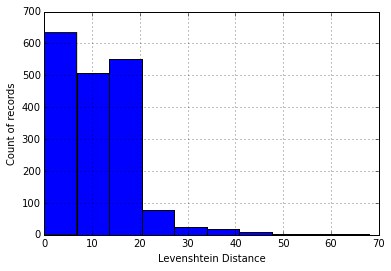

In [19]:
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, replace(a.name, 'Station', '')) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.xlabel("Levenshtein Distance")
pl.ylabel("Count of records")
print df['levenshtein'].hist()

print df['levenshtein'].describe()



Axes(0.125,0.125;0.775x0.775)
count    1827.000000
mean       16.937603
std         7.437542
min         0.000000
25%        11.000000
50%        16.000000
75%        21.000000
max        72.000000
Name: levenshtein, dtype: float64


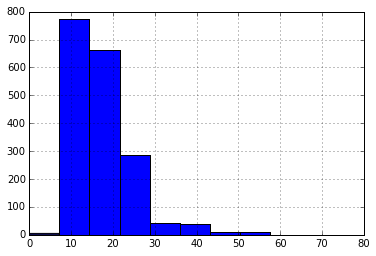

In [7]:
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)
print df['levenshtein'].hist()
print df['levenshtein'].describe()


Axes(0.125,0.125;0.775x0.775)
count    1827.000000
mean        7.769568
std         6.507641
min         0.000000
25%         2.000000
50%         8.000000
75%        10.000000
max        61.000000
Name: levenshtein, dtype: float64


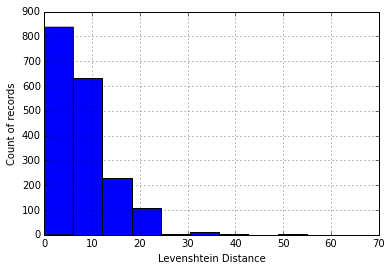

In [22]:
### replace 'Station' and numeric characters
cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, substring(replace(a.name, 'Station', '') from '^[a-zA-Z -]+')) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.xlabel("Levenshtein Distance")
pl.ylabel("Count of records")
print df['levenshtein'].hist()
print df['levenshtein'].describe()


Axes(0.125,0.125;0.775x0.775)
count    1800.000000
mean        7.840207
std         5.764910
min         0.001290
25%         3.578595
50%         6.544205
75%        10.707140
max        43.525053
Name: dis_mi, dtype: float64


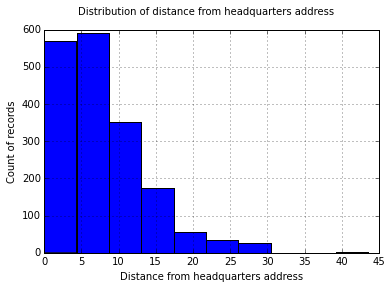

In [33]:
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name), ST_DISTANCE(ST_Transform(e.geom, 900913), ST_Transform(d.geom, 900913)) as dis 
from firestation_usgsstructuredata a 
inner join firestation_firestation b 
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id 
join firecares_core_address d 
  on b.station_address_id=d.id
join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and c.geom is not null;  
  ;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.suptitle("Distribution of distance from headquarters address")
pl.xlabel("Distance from headquarters address")
pl.ylabel("Count of records")

# convert meters to miles.
df['dis_mi'] = df['dis'] * 0.000621371
print df['dis_mi'].hist()
print df['dis_mi'].describe()